In [155]:
import csv
from copy import deepcopy
from fastai.vision import load_learner, open_image, defaults
from fastai.vision import Image as fast_im
from imageio import imwrite
from fastai.core import Path
import torch as torch
from IPython.core.display import HTML
import os
import pandas as pd
display(HTML("<style>.container { width:100% !important; }</style>"))

from line_bounds import *
from matplotlib.pyplot import imshow
from PIL import Image as pil_im
from PIL import ImageEnhance
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import config
from collections import defaultdict
import file_maintenance

In [2]:
defaults.device = torch.device('cpu')

In [158]:
def split(img, split_frac):
    img.data[:,:,int(img.data.shape[2]*split_frac)] = 0
    return img

def split_parts(img, split_frac):
    left_im = img.data[:,:,:int(img.data.shape[2]*split_frac)+1]
    right_im = img.data[:,:,int(img.shape[2]*split_frac):]
    return fast_im(left_im), fast_im(right_im)

In [849]:
master_path = Path('/Users/nicholasbangs/Notebooks/personal/greek_reader_master/')
datapath=master_path/'herodotus'
multi_path = datapath/'split_data'/'multi'
splitter_path =  master_path/'letter_splitter'
class_path = master_path/'models'

In [783]:
splitter_path =  master_path/'letter_splitter'
splitter_name = 'split_model_2.pkl'
splitter = load_learner(splitter_path, splitter_name)

In [784]:
class_name = 'rn_34.pkl'
class_lrnr = load_learner(class_path, class_name)

In [785]:
split_points = dict()
imgs = iter([f for f in multi_path.ls() if '.jpg' in f.name])

In [787]:
# start here

In [ ]:
img_name = next(imgs)
im = open_image(img_name)

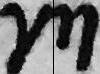

In [839]:
ip = splitter.predict(im)[1][0][1]
frac = .5 + round(float(ip),2) + .02
new_im = split(deepcopy(im),frac); new_im

In [840]:
i1, i2 = split_parts(open_image(img_name), frac)

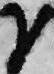

In [841]:
i1

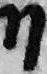

In [842]:
i2

In [843]:
split_points[img_name.name] = float(frac)
preds1 = list(zip(class_lrnr.data.classes, class_lrnr.predict(i1)[2]))
preds2 = list(zip(class_lrnr.data.classes, class_lrnr.predict(i2)[2]))
list(zip(sorted(preds1, key=lambda x: x[1], reverse=True)[:3],sorted(preds2, key=lambda x: x[1], reverse=True)[:3]))


[(('γ', tensor(1.0000)), ('η', tensor(0.9995))),
 (('y', tensor(1.1699e-06)), ('ηiotasub', tensor(0.0004))),
 (('multi', tensor(1.1660e-07)), ('multi', tensor(6.2872e-06)))]

In [859]:
config.letter_dest = splitter_path
file_maintenance.get_letter_dict()

In [861]:
config.letter_dict

{'multi': (186, array([184, 185])),
 'new_multi': (31,
  array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
         28, 29, 30])),
 '.ipynb_checkpoints': (2, array([0, 1]))}

In [862]:
new_sp = dict()
for f in multi_path.ls():
    if '.jpg' in f.name:
        next_id = file_maintenance.get_next_ind('new_multi')
        newname = 'multi_{}.jpg'.format(next_id)
        new_sp[newname] = split_points[f.name]
        os.system('cp {} {}/{}'.format(f, splitter_path/'new_multi', newname))

In [863]:
with open(splitter_path/'letter_split_data.csv','a') as f:
    cw = csv.writer(f)
    for k in new_sp:
        cw.writerow([k, round(new_sp[k],2)])

In [865]:
at_path = datapath/'new_split'/'auto_tags'
os.system('mkdir -p {}'.format(at_path))
item_count = defaultdict(int)

0

In [868]:
for f in multi_path.ls():
    if 'jpg' in f.name:
        frac = split_points[f.name]
        im1, im2 = split_parts(open_image(f), frac)
        im1_label, im2_label = class_lrnr.predict(im1)[0].obj, class_lrnr.predict(im2)[0].obj
        os.system('mkdir -p {}'.format(at_path/im1_label))
        os.system('mkdir -p {}'.format(at_path/im2_label))
        im1.save('{0}/{1}_{2}.jpg'.format(at_path/im1_label, im1_label, item_count[im1_label]))
        im2.save('{0}/{1}_{2}.jpg'.format(at_path/im2_label, im2_label, item_count[im2_label]))
        item_count[im1_label] += 1
        item_count[im2_label] += 1
        